# Sentimental analysis of reviewers' feedback using BERT

**Note:** Retraining the BERT model took a long time to run at local computer, to run in the colab will be a good choice

## Objectives

To predict sentiment (postive, neutral, negeative) of customer feedback using tweet texts of differnt airline companies and compare different models'performace on text classification. 

Specifically, multiple machine learing models such as KNN, Random forest and SVC have been used for conduct classification as a baseline. A new language representation model named BERT (Bidirectional Encoder Representations from Transformers) was also implemented to conduct sentiment analysis. 

## BERT

Bidirectional Encoder Representations from Transformers (BERT) is a technique for NLP (Natural Language Processing) pre-training developed by Google and published in 2018.

BERT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

### How BERT works?

BERT was built on the Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. The attention mechanism was used to extratct information of context of a given words and then encode it in a learned vector. Generally, there are two mechanisms - an encoder that reads the text input and a decoder that produces a prediction for the task.

The detailed workings of Transformer are described in a [paper by Google](https://arxiv.org/abs/1810.04805). Te figure below describe the brief steps of BERT during the traning process.

![](./figs/bert_embedding.png)

where the model takes a pair of sequences and pools the representation of the first token in the sequence. Note that the original BERT model was trained for a masked language model and next-sentence prediction tasks, which includes layers for language model decoding and classification. These layers will not be used for fine-tuning the sentence pair classification.

To help the model distinguish between the two sentences in training, the input is processed in the following way before entering the model:

    1 A [CLS] token is inserted at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.
    2 A sentence embedding indicating Sentence A or Sentence B is added to each token. Sentence embeddings are similar in concept to token embeddings with a vocabulary of 2.
    3 A positional embedding is added to each token to indicate its position in the sequence. The concept and implementation of positional embedding are presented in the Transformer paper.

### Why BERT?

1 BERT offers an advantage over models like Word2Vec, because while each word has a fixed representation under Word2Vec regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by the words around them.

2 As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).


## Data

You can go to [here](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) to download the data used for the project. 

The [deep learning](https://www.kaggle.com/bertcarremans/deep-learning-for-sentiment-analysis) and machine learning to conduct multi-class classification of text can be found [here](https://www.kaggle.com/tankwin08/how-can-we-predict-the-sentiment-by-tweets/edit)



## Refereence

1 [BERT Word Embeddings Tutorial](http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#history)

2 [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
import random
import os

from transformers import TFAutoModel, AutoTokenizer, BertConfig, TFBertModel

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

## 1 Import data

In [3]:
Tweet= pd.read_csv("./data/Tweets.csv")
Tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
(len(Tweet)-Tweet.count())/len(Tweet)

tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373087
negativereason_confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_location                  0.323292
user_timezone                   0.329235
dtype: float64

## 2 Data exploration
### 2.1 drop columns

In [5]:
drop_columns = ['airline_sentiment_gold','negativereason_gold','tweet_coord']
Tweet.drop(drop_columns,axis=1,inplace=True)

In [6]:
Tweet['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [7]:
Tweet['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

### 2.2 Sentiment distribution across different airlines

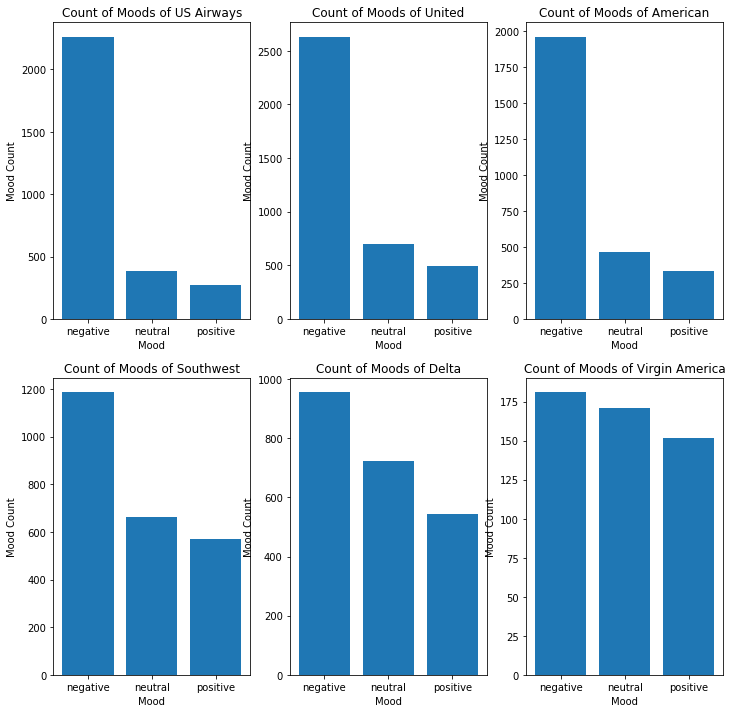

In [8]:
def plot_sub_sentiment(Airline):
    df=Tweet[Tweet['airline']==Airline]
    count=df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count)
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+Airline)
    
    
plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

From the above plots one can find that the distribution of moods for the first three airlines are always skewed toward negative moods. On contrary, the moods are distributed more balanced with the later three airline companies. 

### 2.3 The reason for negative reason for different airlines

In [9]:
def plot_neg_reason(airline):
    if airline == 'all':
        df=Tweet
    else:
        df=Tweet[Tweet['airline']==airline]
        
    ##begin to plot
    count=df['negativereason'].value_counts()
    new_df = pd.DataFrame(count).reset_index().rename(columns={'index':'reason',
                                                              'negativereason':'num'})

    plt.bar(new_df['reason'],new_df['num'])

    plt.xticks(rotation = '80')
    plt.ylabel('Freq')
    plt.xlabel('Reasons for negative')
    plt.title('Count of negative reasons of '+airline)
  

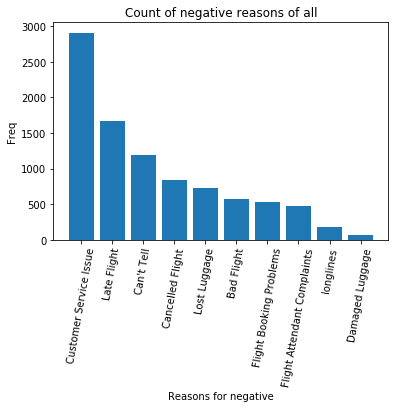

In [10]:
plot_neg_reason('all')

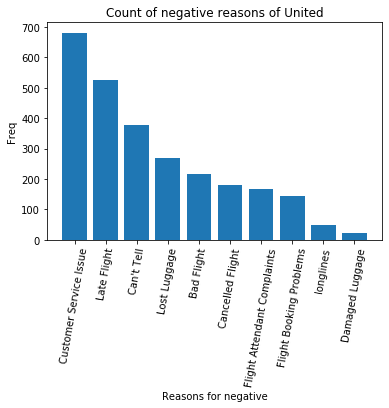

In [11]:
plot_neg_reason('United')

## 3 Word cloud for negative comments

In [12]:
from wordcloud import WordCloud,STOPWORDS

In [13]:
df=Tweet[Tweet['airline_sentiment']=='negative']

words = ' '.join(df['text'])


In [14]:

cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [15]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

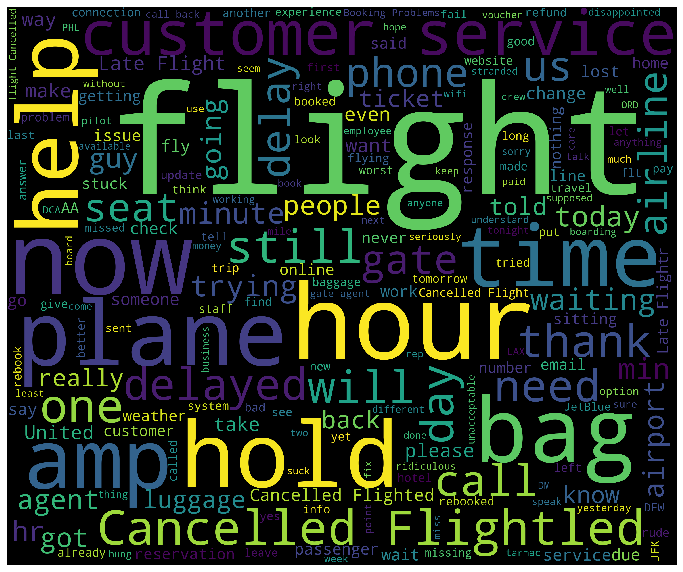

In [16]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**We can find that the Tweets with negative moods are frequently involved some words like cancelled, flight ,customer or hour. People might guess that customer tends to complain when they are waiting for the delayed flights.**

## 4 Preprocess text data

In [17]:
import re
import nltk
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [18]:
raw1 = Tweet['text']

In [19]:
'''input is a text'''
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [20]:
##double check to make sure our function works
Tweet['text'].head(5).apply(text_process)

0                      [VirginAmerica, dhepburn, said]
1    [VirginAmerica, plus, youve, added, commercial...
2    [VirginAmerica, didnt, today, Must, mean, need...
3    [VirginAmerica, really, aggressive, blast, obn...
4             [VirginAmerica, really, big, bad, thing]
Name: text, dtype: object

In [22]:
Tweet['clean_tweet'] = Tweet['text'].apply(text_process)

In [23]:
Tweet.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,clean_tweet
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),"[VirginAmerica, dhepburn, said]"
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),"[VirginAmerica, plus, youve, added, commercial..."


### Feature enginnering using TF-IDF

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)


In [24]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(Tweet['text'])
messages_bow = bow_transformer.transform(Tweet['text'])

In [25]:
## Normalization - TFIDF
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(14640, 19717)


In [26]:
Tweet.shape

(14640, 13)

We can see that every sentences have been represented by a 19717 dimnsion vector. 19717 represents that there are 19717 unique words in our dataset.

In [121]:
## an example
m1 = Tweet['text'][5]
message1 = bow_transformer.transform([m1])
tfidf_mess = tfidf_transformer.transform(message1)

In [124]:
##normalized count values, not just count 
print(tfidf_mess)

  (0, 19298)	0.20146906327895076
  (0, 18062)	0.29019932006515164
  (0, 16990)	0.3049014492187853
  (0, 16911)	0.2449339715518497
  (0, 16206)	0.2358409466205165
  (0, 15692)	0.3831767661080188
  (0, 15502)	0.26307557264626946
  (0, 11301)	0.22529459359618628
  (0, 11198)	0.12050893940426824
  (0, 10242)	0.24468921520518044
  (0, 8488)	0.2535518449506643
  (0, 7441)	0.20043903712977193
  (0, 7377)	0.3885532023638171
  (0, 838)	0.26456015712879355


In [119]:
## count in each sentences
print(message1)

  (0, 838)	1
  (0, 7377)	1
  (0, 7441)	1
  (0, 8488)	1
  (0, 10242)	1
  (0, 11198)	1
  (0, 11301)	1
  (0, 15502)	1
  (0, 15692)	1
  (0, 16206)	1
  (0, 16911)	1
  (0, 16990)	1
  (0, 18062)	1
  (0, 19298)	1


In [120]:
## get word which represented by these itnerger
print(bow_transformer.get_feature_names()[838])
print(bow_transformer.get_feature_names()[7377])

30
VA


### Train and test split

In [27]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages_tfidf, Tweet['airline_sentiment'], test_size=0.2,random_state=42)

In [28]:
print(msg_train.shape[0]), print(msg_test.shape[0])

11712
2928


(None, None)

## 5 Text classification using Machine learning methods

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

In [31]:
Classifiers = [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    GaussianNB()]

In [161]:
dense_features=msg_train.toarray()
dense_test= msg_test.toarray()

In [162]:
Accuracy = []
Model = []

for classifer in Classifiers:
    
    try:
        fit1 = classifer.fit(msg_train, label_train)
        pred = fit1.predict(msg_test)
    except Exception:
        fit1 = classifer.fit(dense_features, label_train)
        pred = fit1.predict(dense_test)
            
    accuracy = accuracy_score(pred,label_test)
    Accuracy.append(accuracy)
    
    Model.append(classifer.__class__.__name__)
    print('Accuracy of '+classifer.__class__.__name__+'is '+str(accuracy)) 
    

Accuracy of LogisticRegressionis 0.6338797814207651
Accuracy of KNeighborsClassifieris 0.6796448087431693
Accuracy of SVCis 0.6338797814207651
Accuracy of DecisionTreeClassifieris 0.673155737704918
Accuracy of RandomForestClassifieris 0.7452185792349727
Accuracy of AdaBoostClassifieris 0.7069672131147541
Accuracy of GaussianNBis 0.5594262295081968


Text(0.5, 1.0, 'Accuracies of Models')

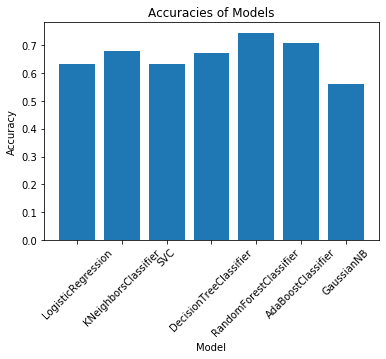

In [163]:
Index = [1,2,3,4,5,6,7]
plt.bar(Index,Accuracy)
plt.xticks(Index, Model,rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')

### Choose the best model - Random forest as baseline


In [32]:
classifer = RandomForestClassifier(n_estimators=200)
fit1 = classifer.fit(msg_train, label_train)
pred = fit1.predict(msg_test)

In [34]:
print(classification_report(label_test,pred))

              precision    recall  f1-score   support

    negative       0.79      0.95      0.86      1889
     neutral       0.63      0.38      0.48       580
    positive       0.78      0.51      0.62       459

    accuracy                           0.77      2928
   macro avg       0.73      0.61      0.65      2928
weighted avg       0.75      0.77      0.75      2928



## 6 Bert model

In [35]:
map_label = dict(enumerate(Tweet['airline_sentiment'].factorize()[1]))

In [36]:
Tweet['airline_sentiment'] = Tweet['airline_sentiment'].factorize()[0]

### Input Formatting
Because BERT is a pretrained model that expects input data in a specific format, we will need:

* 1 A special token, [SEP], to mark the end of a sentence, or the separation between two sentences
* 2 A special token, [CLS], at the beginning of our text. This token is used for classification tasks, but BERT expects it no matter what your application is.
Tokens that conform with the fixed vocabulary used in BERT
* 3 The Token IDs for the tokens, from BERT’s tokenizer
* 4 Mask IDs to indicate which elements in the sequence are tokens and which are padding elements
* 5 Segment IDs used to distinguish different sentences
* 6 Positional Embeddings used to show token position within the sequence

Luckily, the transformers interface takes care of all of the above requirements (using the **tokenizer.encode_plus** function).

In [37]:
### UTILITY FUNCTIONS FOR TOKENIZATIONS, MASKS AND SEGMENTS CREATION ###
### from: https://www.kaggle.com/akensert/bert-base-tf2-0-now-huggingface-transformer

def convert_to_transformer_inputs(str1, str2, tokenizer, max_sequence_length, double=True):
    
    def return_id(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,
            add_special_tokens=True,
            max_length=length,
            truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_masks = [1] * len(input_ids)
        input_segments = inputs["token_type_ids"]
        
        padding_length = length - len(input_ids)
        padding_id = tokenizer.pad_token_id
        
        input_ids = input_ids + ([padding_id] * padding_length)
        input_masks = input_masks + ([0] * padding_length)
        input_segments = input_segments + ([0] * padding_length)
        
        return [input_ids, input_masks, input_segments]
    
    if double:
    
        input_ids_1, input_masks_1, input_segments_1 = return_id(
            str1, None, 'longest_first', max_sequence_length)

        input_ids_2, input_masks_2, input_segments_2 = return_id(
            str2, None, 'longest_first', max_sequence_length)

        return [input_ids_1, input_masks_1, input_segments_1,
                input_ids_2, input_masks_2, input_segments_2]
    
    else:
        
        input_ids, input_masks, input_segments = return_id(
            str1, str2, 'longest_first', max_sequence_length)

        return [input_ids, input_masks, input_segments,
                None, None, None]        

def compute_input_arrays(df, columns, tokenizer, max_sequence_length, double=True):
    
    input_ids_1, input_masks_1, input_segments_1 = [], [], []
    input_ids_2, input_masks_2, input_segments_2 = [], [], []
    for _, instance in tqdm(df[columns].iterrows(), total=len(df)): ##tqdm can give me the progressing bar
        str1, str2 = instance[columns[0]], instance[columns[1]]

        ids_1, masks_1, segments_1, ids_2, masks_2, segments_2 = \
        convert_to_transformer_inputs(str1, str2, tokenizer, max_sequence_length, double=double)
        
        input_ids_1.append(ids_1)
        input_masks_1.append(masks_1)
        input_segments_1.append(segments_1)

        input_ids_2.append(ids_2)
        input_masks_2.append(masks_2)
        input_segments_2.append(segments_2)
        
    if double:
        
        return [np.asarray(input_ids_1, dtype=np.int32), 
                np.asarray(input_masks_1, dtype=np.int32), 
                np.asarray(input_segments_1, dtype=np.int32),
                np.asarray(input_ids_2, dtype=np.int32), 
                np.asarray(input_masks_2, dtype=np.int32), 
                np.asarray(input_segments_2, dtype=np.int32)]
    
    else:
        
        return [np.asarray(input_ids_1, dtype=np.int32), 
                np.asarray(input_masks_1, dtype=np.int32), 
                np.asarray(input_segments_1, dtype=np.int32)]

In [38]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(Tweet[['text','clean_tweet']], Tweet['airline_sentiment'].values, 
                                                    random_state=42, test_size = 0.2)
del Tweet

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(11712, 2) (2928, 2)
(11712,) (2928,)


## The pre-trained model
Google released a few variations of BERT models, but the one we’ll use here is the smaller of the two available sizes (“base” and “large”) and ignores casing, hence “uncased.””

Transformers provides a number of classes for applying BERT to different tasks (token classification, text classification, …). Here, we’re using the basic BertModel which has no specific output task–it’s a good choice for using BERT just to extract embeddings.

In [40]:
### IMPORT TOKENIZER ###

MAX_SEQUENCE_LENGTH = 300

# Load pre-trained model tokenizer (vocabulary)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

### Simple BERT (ONE INPUT)

In [41]:
### CREATE SEQUENCES (id, mask, segments) FOR TRAIN AND TEST ###

input_train = compute_input_arrays(X_train, ['text','clean_tweet'], tokenizer, MAX_SEQUENCE_LENGTH, double=False)
input_test = compute_input_arrays(X_test, ['text','clean_tweet'], tokenizer, MAX_SEQUENCE_LENGTH, double=False)

In [42]:
def simple_bert():
    
    opt = Adam(learning_rate=2e-5)
    
    id_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    mask_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    atn_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig()
    config.output_hidden_states = False # Set to True to obtain hidden states
    bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    
    embedding = bert_model(id_, attention_mask=mask_, token_type_ids=atn_)[0]
    
    x = GlobalAveragePooling1D()(embedding)    
    x = Dropout(0.2)(x)
    out = Dense(len(map_label), activation='softmax')(x)

    model = Model(inputs=[id_, mask_, atn_], outputs=out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
    
    return model

In [43]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

model = simple_bert()
model.fit(input_train, y_train, epochs=3, batch_size=6)

Train on 11712 samples
Epoch 1/3
11712/11712 [==============================] - 41649s 4s/sample - loss: 0.4699
Epoch 2/3
11712/11712 [==============================] - 41430s 4s/sample - loss: 0.2663
Epoch 3/3
11712/11712 [==============================] - 41971s 4s/sample - loss: 0.1318


In [44]:
pred_test = model.predict(input_test), axis=1)

In [49]:
map_label

{0: 'neutral', 1: 'positive', 2: 'negative'}

In [51]:
print(classification_report([map_label[i] for i in y_test], [map_label[i] for i in pred_test]))

              precision    recall  f1-score   support

    negative       0.85      0.96      0.90      1889
     neutral       0.79      0.46      0.58       580
    positive       0.78      0.77      0.78       459

    accuracy                           0.83      2928
   macro avg       0.81      0.73      0.75      2928
weighted avg       0.82      0.83      0.82      2928



In [52]:
confusion_matrix(y_test,pred_test)

array([[ 264,   67,  249],
       [  25,  355,   79],
       [  47,   31, 1811]], dtype=int64)

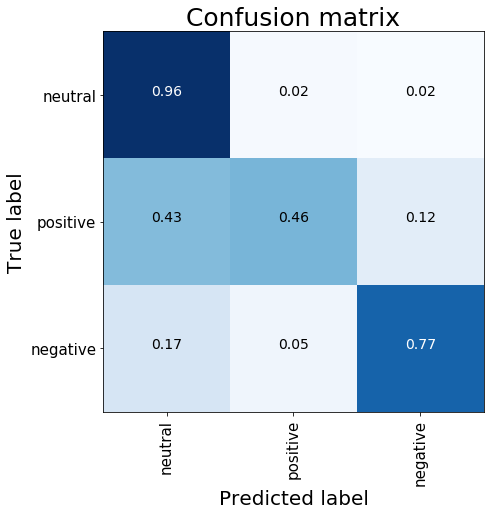

In [50]:
cnf_matrix = confusion_matrix([map_label[i] for i in y_test], 
                              [map_label[i] for i in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()))
plt.show()

## Conclusions

Comapred to best machine learning method, the simple BERT model can generated better results in terms of confusion matrix and overall accuracy. 

The BERT model can be improved if we can added more external variables as input for the model. 